In [2]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


In [3]:
tf.enable_eager_execution()


In [4]:
# So for a model thats roughly just starting out... what do its logits look like...
detail = {
 'model_loc': 'history/2019-12-29T000509Z/epoch_000_batch_00030_model.h5', 
    'test_loc': 'history/2019-12-22T174803Z/test_balanced.h5', 
 'batch_size': '32', 
 #'work_dir': 'history/2020-01-04T1945Z'
}


In [ ]:
# Borrowing from earlier notebook...
# https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-01-loglossbook--update.md

def get_raw_preds(model, dataloc, dataset_names):
    # dataloc contains the test data..
    lossvec = []
    predsvec = []
    for Xdataset, Ydataset in tqdm(dataset_names):

        X, Ylabels = mu.read_h5_two(dataloc, Xdataset, Ydataset) 
        parts = mu.get_partitions(range(X.shape[0]), 100)
        batchlosses = []
        for part in parts:
            preds = model(X[part].astype('float32'))
            loss = tf.losses.sparse_softmax_cross_entropy(
                        labels=Ylabels[part].astype('int64'),
                        logits=preds.numpy()).numpy()
            batchlosses.append(loss)
            predsvec.extend(preds)

        lossvec.append(np.mean(batchlosses))
    return lossvec, predsvec

def plot_logits(vec, title=''):
    plt.plot([x[0] for x in vec], color='blue', label='0')
    plt.plot([x[1] for x in vec], color='green', label='1')
    plt.plot([x[2] for x in vec], color='red', label='2')
    plt.plot([x[3] for x in vec], color='orange', label='3')
    plt.title(title)
    plt.legend()
    
# modelloc = f'history/2019-12-08T220612Z/{modeln}'
model = mu.load_model(detail['model_loc'])

lossvec, predsvec = get_raw_preds(
                    model=model,
                    dataloc=detail['test_loc'],
                    dataset_names=[['X_0', 'Ylabels_0'],
                                  ])
predarr = np.vstack([x.numpy() for x in predsvec])

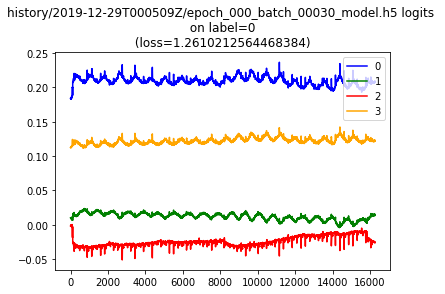

In [11]:
plot_logits(predarr, f'{detail["model_loc"]} logits \n on label=0 \n (loss={lossvec[0]}) ')

In [12]:
%%time
label_logits_vec = {}

for label in tqdm(range(4)):
    print(f'label {label}')
    lossvec, predsvec = get_raw_preds(
                        model=model,
                        dataloc=detail['test_loc'],
                        dataset_names=[[f'X_{label}', f'Ylabels_{label}'],
                                      ])
    predarr = np.vstack([x.numpy() for x in predsvec])
    label_logits_vec[label] = [lossvec, predarr]

  0%|          | 0/1 [00:00<?, ?it/s]

label 0



  0%|          | 0/1 [00:00<?, ?it/s]

label 1



  0%|          | 0/1 [00:00<?, ?it/s]

label 2



  0%|          | 0/1 [00:00<?, ?it/s]

label 3



100%|██████████| 4/4 [02:04<00:00, 31.18s/it]

CPU times: user 2min 3s, sys: 389 ms, total: 2min 4s
Wall time: 2min 4s


using detail["model_loc"]


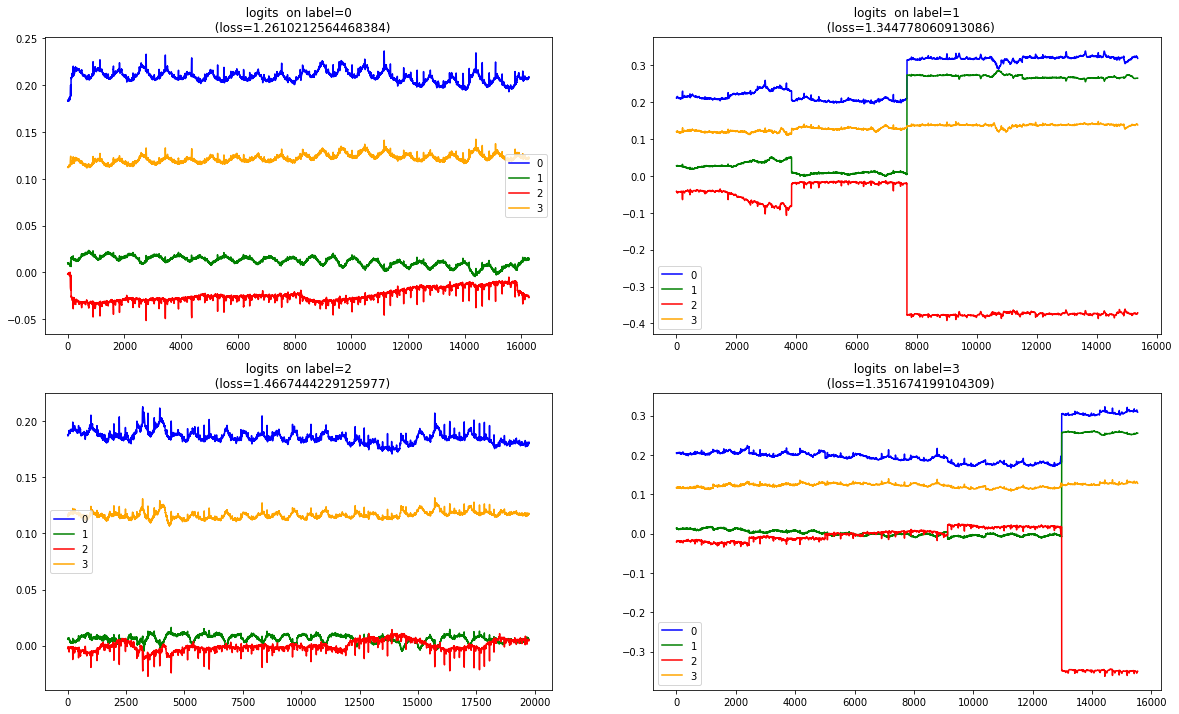

In [21]:

def plot_logits_ax(vec, ax, title=''):
    ax.plot([x[0] for x in vec], color='blue', label='0')
    ax.plot([x[1] for x in vec], color='green', label='1')
    ax.plot([x[2] for x in vec], color='red', label='2')
    ax.plot([x[3] for x in vec], color='orange', label='3')
    ax.set(title=title)
    #ylabel=col,
    #xlabel='time')

    ax.legend()

fig = plt.figure(figsize=(20,12))


for i in range(4):
    ax = fig.add_subplot(int('22' + str(i+1)))
    plot_logits_ax(vec=label_logits_vec[i][1], 
                   ax=ax, 
                   title=(f'  logits '
                          f' on label={i}  \n '
                          f' (loss={label_logits_vec[i][0][0]})'))

                   

print(f'using detail["model_loc"]')
